In [1]:
! pip install pandas
! pip install boto3
! pip install watchtower
! pip install s3fs==0.4.2
! pip install pyathena
! pip install matplotlib
! pip install scipy
! pip install ipywidgets
! pip install scikit-learn

! conda install -c conda-forge --yes implicit 

! pip install --upgrade jupyter_client # useful to make ipywidgets work properly when fitting data with implicit

# pip install git+https://gitlab.com/cloena/cloena-aws-tools.git

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrad

In [1]:
import pandas as pd

import s3fs

import pickle

import implicit

from aws_tools import athena_tools, s3_tools

import matplotlib

import re

import scipy

from ipywidgets import FloatProgress

import numpy as np

from sklearn.preprocessing import MinMaxScaler

from datetime import datetime

/home/ec2-user/.local/lib/python3.6/site-packages/aws_tools/project_config.py:18: UserWarning: no aws_config.json file found
  warnings.warn('no aws_config.json file found')


In [2]:
_v = '_v0.2'

In [3]:
data_views = pd.read_csv('s3://bt-data-science-playground/bt-tv-recommendation-system/model_objects/historicalviews'+_v+'.csv')
data_purren = pd.read_csv('s3://bt-data-science-playground/bt-tv-recommendation-system/model_objects/historicalpurchasesrentals'+_v+'.csv')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
data_views.head()

,ID_USER,TYPE_SLOT,TYPE_ASSET,VIEW_DATE,TITLE,TYPE,END_DATE,ID_EDITORIAL,GENRE,RATING
0,BBEU32029145,Feature,episode,2019-06-29 16:09:09,Teen Titans Go! Series 3,season,2020-06-27 14:59:00,movida_10008002,6 Years +,u
1,BBEU29937057,Feature,episode,2019-06-29 08:27:09,Teen Titans Go! Series 3,season,2020-06-27 14:59:00,movida_10008002,6 Years +,u
2,BBEU33421092,Feature,episode,2019-06-29 18:38:24,Teen Titans Go! Series 3,season,2020-06-27 14:59:00,movida_10008002,6 Years +,u
3,BBEU18833349,Feature,episode,2019-06-29 16:22:29,Teen Titans Go! Series 3,season,2020-06-27 14:59:00,movida_10008002,6 Years +,u
4,BBEU27799836,Feature,episode,2019-06-29 08:11:53,Teen Titans Go! Series 3,season,2020-06-27 14:59:00,movida_10008002,6 Years +,u


In [5]:
data_purren.head()

,ID_USER,TYPE_ASSET,TYPE_ENTITLEMENT,PRICE,PURCHASE_DATE,TITLE,TYPE,END_DATE,ID_EDITORIAL,GENRE,RATING
0,BBEU05449846,Film,TVOD,4.49,2020-05-27 00:03:22,Bad Boys for Life,film,2020-09-12 22:59:00,BBJ2550316A,Action,15
1,BBEU37034914,Film,TVOD,4.49,2020-05-27 08:52:36,Bad Boys for Life,film,2020-09-12 22:59:00,BBJ2550316A,Action,15
2,BBEU34520852,Film,TVOD,4.49,2020-05-27 09:27:01,Bad Boys for Life,film,2020-09-12 22:59:00,BBJ2550316A,Action,15
3,BBEU36931493,Film,TVOD,4.49,2020-05-27 13:15:53,Bad Boys for Life,film,2020-09-12 22:59:00,BBJ2550316A,Action,15
4,BBEU08836976,Film,TVOD,4.49,2020-05-27 13:07:31,Bad Boys for Life,film,2020-09-12 22:59:00,BBJ2550316A,Action,15


In [6]:
data_views = data_views.rename(columns={'VIEW_DATE': 'EVENT_DATE'})
data_purren = data_purren.rename(columns={'PURCHASE_DATE': 'EVENT_DATE'})

data_views['TYPE_ENTITLEMENT'] = 'VIEW'

In [7]:
cols = ['ID_USER', 'ID_EDITORIAL', 'TITLE', 'GENRE', 'RATING', 'TYPE', 'TYPE_ASSET', 'END_DATE', 'EVENT_DATE', 'TYPE_ENTITLEMENT']

data_views = data_views[cols]
data_purren = data_purren[cols]

data_implicit = data_views.append(data_purren, ignore_index=True)
del data_views
del data_purren

In [8]:
DROP_MUSIC = True
if DROP_MUSIC:
    data_implicit = data_implicit[data_implicit['TYPE_ASSET'] != 'Music']
else:
    pass

In [9]:
# Calculate sparsity 
n_users = data_implicit['ID_USER'].unique().shape[0]
n_items = data_implicit['ID_EDITORIAL'].unique().shape[0]

print('Number of users: {}'.format(n_users))
print('Number of items: {}'.format(n_items))
print('Sparsity: {:4.3f}%'.format(float(data_implicit.shape[0]) / float(n_users*n_items) * 100))

Number of users: 961307
Number of items: 23815
Sparsity: 0.259%


In [10]:
data_implicit['TYPE_ENTITLEMENT'].value_counts()

VIEW    56764816
TVOD     1570726
EVOD      813002
PPV        96561
Name: TYPE_ENTITLEMENT, dtype: int64

In [11]:
# based on type of entitlement (purchase/rental/ppv/view) give different strength [EVOD=purchase;TVOD=rental]
def assign_eventStrength(x):
    if x == 'EVOD':
        val = 3
    elif x == 'TVOD':
        val = 2
    elif x == 'PPV':
        val = 3
    elif x == 'VIEW':
        val = 1
    else:
        val = 1
    return val

data_implicit['eventStrength'] = data_implicit['TYPE_ENTITLEMENT'].apply(assign_eventStrength)

In [12]:
data_implicit['TITLE'] = data_implicit['TITLE'].astype("category")
data_implicit['ID_USER'] = data_implicit['ID_USER'].astype("category")
data_implicit['ID_EDITORIAL'] = data_implicit['ID_EDITORIAL'].astype("category")
data_implicit['ID_USER_simple'] = data_implicit['ID_USER'].cat.codes
data_implicit['ID_EDITORIAL_simple'] = data_implicit['ID_EDITORIAL'].cat.codes

data_implicit.head()

,ID_USER,ID_EDITORIAL,TITLE,GENRE,RATING,TYPE,TYPE_ASSET,END_DATE,EVENT_DATE,TYPE_ENTITLEMENT,eventStrength,ID_USER_simple,ID_EDITORIAL_simple
0,BBEU32029145,movida_10008002,Teen Titans Go! Series 3,6 Years +,u,season,episode,2020-06-27 14:59:00,2019-06-29 16:09:09,VIEW,1,810934,15937
1,BBEU29937057,movida_10008002,Teen Titans Go! Series 3,6 Years +,u,season,episode,2020-06-27 14:59:00,2019-06-29 08:27:09,VIEW,1,754480,15937
2,BBEU33421092,movida_10008002,Teen Titans Go! Series 3,6 Years +,u,season,episode,2020-06-27 14:59:00,2019-06-29 18:38:24,VIEW,1,847352,15937
3,BBEU18833349,movida_10008002,Teen Titans Go! Series 3,6 Years +,u,season,episode,2020-06-27 14:59:00,2019-06-29 16:22:29,VIEW,1,364895,15937
4,BBEU27799836,movida_10008002,Teen Titans Go! Series 3,6 Years +,u,season,episode,2020-06-27 14:59:00,2019-06-29 08:11:53,VIEW,1,662082,15937


In [13]:
sparse_content_person = scipy.sparse.csr_matrix(
    (data_implicit['eventStrength'].astype(float), (data_implicit['ID_EDITORIAL_simple'], data_implicit['ID_USER_simple']))
)
sparse_person_content = scipy.sparse.csr_matrix(
    (data_implicit['eventStrength'].astype(float), (data_implicit['ID_USER_simple'], data_implicit['ID_EDITORIAL_simple']))
)

In [14]:
%%time

model = implicit.als.AlternatingLeastSquares(factors=30, regularization=0.1, iterations=50)
alpha = 15
data_tofit = (sparse_content_person * alpha).astype('double')
model.fit(data_tofit)

2020-07-01 13:49:39,946 [WARNI]  Intel MKL BLAS detected. Its highly recommend to set the environment variable 'export MKL_NUM_THREADS=1' to disable its internal multithreading



CPU times: user 15min 31s, sys: 4.49 s, total: 15min 35s
Wall time: 59.9 s


In [15]:
# Turn duplicate the RATING column in a form that is numeric so that they can be compared
def rating_toNumeric(x):
    if x == 'u':
        return 0
    elif x == 'pg':
        return 1
    elif x == '12':
        return 2
    elif x == '15':
        return 3
    elif x == '18':
        return 4
    else:
        return 5
    
data_implicit['RATING_n'] = data_implicit['RATING'].apply(rating_toNumeric)

data_implicit.head()

,ID_USER,ID_EDITORIAL,TITLE,GENRE,RATING,TYPE,TYPE_ASSET,END_DATE,EVENT_DATE,TYPE_ENTITLEMENT,eventStrength,ID_USER_simple,ID_EDITORIAL_simple,RATING_n
0,BBEU32029145,movida_10008002,Teen Titans Go! Series 3,6 Years +,u,season,episode,2020-06-27 14:59:00,2019-06-29 16:09:09,VIEW,1,810934,15937,0
1,BBEU29937057,movida_10008002,Teen Titans Go! Series 3,6 Years +,u,season,episode,2020-06-27 14:59:00,2019-06-29 08:27:09,VIEW,1,754480,15937,0
2,BBEU33421092,movida_10008002,Teen Titans Go! Series 3,6 Years +,u,season,episode,2020-06-27 14:59:00,2019-06-29 18:38:24,VIEW,1,847352,15937,0
3,BBEU18833349,movida_10008002,Teen Titans Go! Series 3,6 Years +,u,season,episode,2020-06-27 14:59:00,2019-06-29 16:22:29,VIEW,1,364895,15937,0
4,BBEU27799836,movida_10008002,Teen Titans Go! Series 3,6 Years +,u,season,episode,2020-06-27 14:59:00,2019-06-29 08:11:53,VIEW,1,662082,15937,0


In [16]:
# Save model object and data
fs = s3fs.S3FileSystem(anon=False) 
with fs.open('s3://bt-data-science-playground/bt-tv-recommendation-system/model_objects/model_views-purchases-rentals-ppv'+_v+'.pkl', 'wb') as f:
        pickle.dump(model, f)
#
data_implicit.to_csv('s3://bt-data-science-playground/bt-tv-recommendation-system/model_objects/modeldata_views-purchases-rentals-ppv'+_v+'.csv', index=False)

In [17]:
content_id = 2439
n_similar = 10

content_vecs = model.item_factors

# cosine similarity where A is any item, and B is the item of interest

content_norms = np.sqrt((content_vecs * content_vecs).sum(axis=1)) # i.e. calculating abs. value of the vector of each item -->  |A|

scores = content_vecs.dot(content_vecs[content_id])  / (content_norms * content_vecs[content_id].sum()) # i.e. calculating cosine similarity, (A.B) / (|A| x |B|) --> |B| just a constant so effectively won't need it

top_idx = scores.argsort()
similar = sorted(zip(top_idx, scores[top_idx]), key=lambda x: -x[1])

counter = 1
for content in similar:
    if counter <= n_similar:
        
        idx, score = content
        
        # show only if still available 
        if pd.to_datetime(data_implicit['END_DATE'].loc[data_implicit['ID_EDITORIAL_simple'] == idx].iloc[0]) > datetime.now():
            
            # show only if rating is as selected item or lower
            if data_implicit['RATING_n'].loc[data_implicit['ID_EDITORIAL_simple'] == idx].iloc[0] <= data_implicit['RATING_n'].loc[data_implicit['ID_EDITORIAL_simple'] == content_id].iloc[0]:

                print(data_implicit['TITLE'].loc[data_implicit['ID_EDITORIAL_simple'] == idx].iloc[0])

                counter = counter + 1
            
    else:
        break

Wonder Woman
Doctor Strange
X-Men: Apocalypse
Justice League
Ant-Man
Guardians of the Galaxy Vol. 2 [Bonus Edition]
Avengers: Age of Ultron
Star Trek Beyond
Guardians of the Galaxy
Captain America: The Winter Soldier


In [18]:
#data_implicit[data_implicit['TITLE'].str.lower().str.contains("frozen")].head(10)
data_implicit[data_implicit['TITLE']=='Wonder Woman'].head(1)

,ID_USER,ID_EDITORIAL,TITLE,GENRE,RATING,TYPE,TYPE_ASSET,END_DATE,EVENT_DATE,TYPE_ENTITLEMENT,eventStrength,ID_USER_simple,ID_EDITORIAL_simple,RATING_n
38102950,BBEU23780068,BBJ1442961A,Wonder Woman,Action,12,film,film,2025-12-31 23:59:00,2018-08-19 14:06:50,VIEW,1,522540,2439,2


In [19]:
# one hot encode the genre tag to add as features for the More Like This

genres = data_implicit[['ID_EDITORIAL_simple', 'TITLE', 'GENRE']]
genres = genres.drop_duplicates(subset='ID_EDITORIAL_simple')
genres = genres.sort_values(by='ID_EDITORIAL_simple').reset_index(drop=True)
genres.head()

,ID_EDITORIAL_simple,TITLE,GENRE
0,0,Day 4 - Pt 3,Tennis
1,1,Athletics: EAA Classic - Lucerne Pt1,Athletics
2,2,Athletics: EAA Classic - Lucerne Pt2,Athletics
3,3,Stage 11 - Highlights,Motor Sport
4,4,6 Hours of Silverstone - Review,Motorsport


In [20]:
genres_dummies = pd.get_dummies(genres['GENRE'], prefix='GENRE')

genres_dummies.head()

,GENRE_2 - 5 Years,GENRE_6 Years +,GENRE_Action,GENRE_Adventure,GENRE_All,GENRE_Alternative Rock,GENRE_Animation,GENRE_Athletics,GENRE_Aussie Rules Football,GENRE_Baby,...,GENRE_Thriller,GENRE_UFC,GENRE_Water Sports,GENRE_Watersports,GENRE_Western,GENRE_Westerns,GENRE_Wintersports,GENRE_World Cinema,GENRE_Wrestling,GENRE_eSports
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
content_id = 2439
n_similar = 10

content_vecs = model.item_factors

# trasnform to dataframe to stack with genre one hot encoded features
content_vecs = pd.DataFrame(content_vecs)

# create list of feature dataframes to stack in case one of the sets needs to be multiplied to make more prominent
# can improve by looking at size of features of the two sets, e.g. if one hot encoding gives 90 features vs 30 chosen for synthetic ones genre will automatically be more important and synthetic sets may need to be multiplied by an equivalent factor
importance_syntheticFeatures = 6
importance_onehotencodedFeatures = 1
to_stack = [content_vecs]*importance_syntheticFeatures + [genres_dummies]*importance_onehotencodedFeatures

# Stack horizontally features coming from collaborativ filtering & genre one hot encoding
content_vecs = pd.concat(to_stack, axis=1)

# cosine similarity where A is any item, and B is the item of interest
content_norms = np.sqrt((content_vecs * content_vecs).sum(axis=1)) # i.e. calculating abs. value of the vector of each item -->  |A|

scores = content_vecs.dot(content_vecs.iloc[content_id,:])  / (content_norms * content_vecs.iloc[content_id,:].sum()) # i.e. calculating cosine similarity, (A.B) / (|A| x |B|) --> |B| just a constant so effectively won't need it

top_idx = scores.argsort()
similar = sorted(zip(top_idx, scores[top_idx]), key=lambda x: -x[1])

counter = 1
for content in similar:
    if counter <= n_similar:
        
        idx, score = content
        
        # show only if still available 
        if pd.to_datetime(data_implicit['END_DATE'].loc[data_implicit['ID_EDITORIAL_simple'] == idx].iloc[0]) > datetime.now():
            
            # show only if rating is as selected item or lower
            if data_implicit['RATING_n'].loc[data_implicit['ID_EDITORIAL_simple'] == idx].iloc[0] <= data_implicit['RATING_n'].loc[data_implicit['ID_EDITORIAL_simple'] == content_id].iloc[0]:
            
                print(data_implicit['TITLE'].loc[data_implicit['ID_EDITORIAL_simple'] == idx].iloc[0])

                counter = counter + 1
            
    else:
        break

2020-07-01 14:17:18,802 [INFO ]  Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2020-07-01 14:17:18,802 [INFO ]  NumExpr defaulting to 8 threads.


Wonder Woman
Doctor Strange
X-Men: Apocalypse
Ant-Man
Justice League
Captain America: The Winter Soldier
Man of Steel
Avengers: Age of Ultron
Iron Man 3
Guardians of the Galaxy


In [22]:
# Get the trained person and content vectors. We convert them to csr matrices
person_vecs = scipy.sparse.csr_matrix(model.user_factors)
content_vecs = scipy.sparse.csr_matrix(model.item_factors)

In [27]:
# Create recommendations for person with a given id 
person_id = 21

# Number of content items to get
num_contents=10

# Get the interactions scores from the sparse person content matrix
person_interactions = sparse_person_content[person_id,:].toarray()
# Add 1 to everything, so that articles with no interaction yet become equal to 1
person_interactions = person_interactions.reshape(-1) + 1
# Make articles already interacted zero
person_interactions[person_interactions > 1] = 0
# Get dot product of person vector and all content vectors
rec_vector = person_vecs[person_id,:].dot(content_vecs.T).toarray()

# Scale this recommendation vector between 0 and 1
min_max = MinMaxScaler()
rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0]

dithering = True
if dithering:
    # Dithering score is caclulated as:
    # dithScore = log10(rank) + N(0,log10(eps)), where eps is generally between 1.5 & 3.0
    eps = 1.5
    rank = np.argsort(np.argsort(-rec_vector.reshape(-1,1)[:,0])) # for rec_vector_scaled the higher the better
    dithScore = np.log10(rank+1) + np.random.normal(0.0, np.sqrt(np.log10(eps)), len(rank)) # make rank start from 1 not zero
    # for dithScore the lower the better
    
    # Content already interacted will effectively have their recommendation multiplied by zero
    recommend_vector = person_interactions * (-dithScore + max(dithScore)) # multiply this way to effectively make the best score being the highest again
    
    content_idx = np.argsort(recommend_vector)[::-1]
    
else:
    # Content already interacted will effectively have their recommendation multiplied by zero
    recommend_vector = person_interactions * rec_vector_scaled
    
    # Sort the indices of the content into order of best recommendations
    content_idx = np.argsort(recommend_vector)[::-1]

# Start empty list to store titles and scores
titles = []
scores = []
content_ids = []

idx = 0
counter = 0
max_user_rating = max(data_implicit['RATING_n'].loc[data_implicit['ID_USER_simple'] == person_id])
while counter < num_contents:
    
    # show only if still available 
    if pd.to_datetime(data_implicit['END_DATE'].loc[data_implicit['ID_EDITORIAL_simple'] == content_idx[idx]].iloc[0]) > datetime.now():
        
        # check that item has rating as or lower of highest watched by user
        if data_implicit['RATING_n'].loc[data_implicit['ID_EDITORIAL_simple'] == content_idx[idx]].iloc[0] <= max_user_rating:

            # Append titles and scores to the list
            titles.append(data_implicit['TITLE'].loc[data_implicit['ID_EDITORIAL_simple'] == content_idx[idx]].iloc[0])
            scores.append(recommend_vector[content_idx[idx]])
            content_ids.append(content_idx[idx])

            counter = counter + 1
    idx = idx + 1
recommendations = pd.DataFrame({'title': titles, 'score': scores, 'ids' : content_ids})
print(recommendations)

                                       title     score    ids
0                 Project Blue Book Series 1  5.603450  20384
1                       The Outpost Series 1  5.187633  17681
2                        Knightfall Series 1  5.032188  18426
3             Fear The Walking Dead Series 5  4.995443  20638
4       Faking It: Tears Of A Crime Series 3  4.845451  21128
5                      The Resident Series 2  4.836956  18116
6                       Chicago Med Series 4  4.438861  18114
7                  The Face of Evil Series 1  4.370236  20686
8                             Stan and Ollie  4.239924   6104
9  Kids Behind Bars: Life Or Parole Series 1  4.216251  20514


In [28]:
'''If dithering is False getting:
                            title     score    ids
0      Project Blue Book Series 1  1.000000  20384
1             Knightfall Series 1  0.954474  18426
2            The Outpost Series 1  0.916203  17681
3  Fear The Walking Dead Series 5  0.864284  20638
4             Knightfall Series 2  0.861949  20869
5        Proven Innocent Series 1  0.859136  20291
6           The Resident Series 2  0.826743  18116
7            Chicago Med Series 4  0.784589  18114
8      Marvel's Runaways Series 1  0.779411  18198
9        Homicide Hunter Series 7  0.723764  18633
'''

"If dithering is False getting:\n                            title     score    ids\n0      Project Blue Book Series 1  1.000000  20384\n1             Knightfall Series 1  0.954474  18426\n2            The Outpost Series 1  0.916203  17681\n3  Fear The Walking Dead Series 5  0.864284  20638\n4             Knightfall Series 2  0.861949  20869\n5        Proven Innocent Series 1  0.859136  20291\n6           The Resident Series 2  0.826743  18116\n7            Chicago Med Series 4  0.784589  18114\n8      Marvel's Runaways Series 1  0.779411  18198\n9        Homicide Hunter Series 7  0.723764  18633\n"

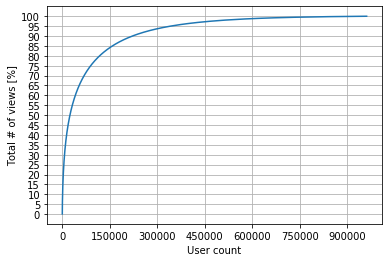

In [24]:
# Calculate how many users have watched X% of the content
idx = data_implicit['ID_USER'].value_counts().index.tolist()
counts = data_implicit['ID_USER'].value_counts().tolist()

user_count = []
percentage_activity = []
activity_so_far = 0
total_activity = sum(counts)

for u in range(len(idx)):
    
    user_count.append(u+1)
    
    activity_so_far = activity_so_far + counts[u]
    percentage_so_far = activity_so_far / total_activity * 100
    percentage_activity.append(percentage_so_far)
     
import matplotlib.pyplot as plt

plt.plot(user_count, percentage_activity)
plt.xlabel('User count')
plt.ylabel('Total # of activity [%]')
plt.grid()
plt.yticks(np.arange(0,105, 5))
plt.xticks(np.arange(0,1000000, 150000))
plt.show()